In [1]:
# Julia version of the code for Chapter 5.2 in Herbst and Schorfheide (2015)
# Author: Takeki Sunakawa
# Mail: takeki.sunakawa@gmail.com
# Last updated: April 19, 2019 @ Cafe de Crie, Kobe Motomachi

using DelimitedFiles
using Random
using ControlSystems # not in CoCalc
using Distributions # not in CoCalc
using PDMats # not in CoCalc
using StatsBase # not in CoCalc
using Plots
include("gensys.jl")

new_div (generic function with 1 method)

In [2]:
struct Model{TF<:AbstractFloat}
    tau::TF
    kappa::TF
    psi1::TF
    psi2::TF
    rA::TF
    piA::TF
    gammaQ::TF
    rho_R::TF
    rho_g::TF
    rho_z::TF
    sigma_R::TF
    sigma_g::TF
    sigma_z::TF
end

In [3]:
function model_solution(m)

    bet = 1/(1+m.rA/400)

    # Equation indices

    eq_1   = 1  #** (2.1) on \hat{y}(t) **/
    eq_2   = 2  #** (2.1) on \hat{pi}(t) **/
    eq_3   = 3  #** (2.1) on \hat{R}(t) **/
    eq_4   = 4  #** \hat{y}(t-1) **/
    eq_5   = 5  #** \hat{g} process **/
    eq_6   = 6  #** \hat{z} process **/
    eq_7   = 7  #** \hat{y} expectational error **/
    eq_8   = 8  #** \hat{pi} expectational error **/

    # Variable indices 

    y_t    = 1
    pi_t   = 2
    R_t    = 3
    y1_t   = 4
    g_t    = 5
    z_t    = 6
    Ey_t1  = 7
    Epi_t1 = 8

    # Expectation error indices (eta) 

    ey_sh  = 1
    epi_sh = 2       

    # Shock indices (eps)

    z_sh = 1
    g_sh = 2
    R_sh = 3

    # SUMMARY

    neq  = 8
    neta = 2
    neps = 3

    # /** initialize matrices **/

    GAM0 = zeros(neq,neq)
    GAM1 = zeros(neq,neq)
       C = zeros(neq,1)        
     PSI = zeros(neq,neps)
     PPI = zeros(neq,neta)


    # =========================================================================
    #                 EQUILIBRIUM CONDITIONS: CANONICAL SYSTEM
    # =========================================================================

    # =========================================================================
    #          1. 
    # =========================================================================

    GAM0[eq_1,y_t] =  1
    GAM0[eq_1,R_t] =  1/m.tau
    GAM0[eq_1,g_t] = -(1-m.rho_g)
    GAM0[eq_1,z_t] = -m.rho_z/m.tau
    GAM0[eq_1,Ey_t1] = -1
    GAM0[eq_1,Epi_t1] = -1/m.tau

    # =========================================================================
    #          2. 
    # =========================================================================

    GAM0[eq_2,y_t] = -m.kappa;
    GAM0[eq_2,pi_t] = 1;
    GAM0[eq_2,g_t] =  m.kappa;
    GAM0[eq_2,Epi_t1] = -bet;

    # =========================================================================
    #          3. 
    # =========================================================================

    GAM0[eq_3,y_t] = -(1-m.rho_R)*m.psi2
    GAM0[eq_3,pi_t] = -(1-m.rho_R)*m.psi1
    GAM0[eq_3,R_t] = 1
    GAM0[eq_3,g_t] = (1-m.rho_R)*m.psi2
    GAM1[eq_3,R_t] = m.rho_R
    PSI[eq_3,R_sh] = 1

    # =========================================================================
    #          4. 
    # =========================================================================

    GAM0[eq_4,y1_t] = 1
    GAM1[eq_4,y_t] = 1

    # =========================================================================
    #          5. 
    # =========================================================================

    GAM0[eq_5,g_t] = 1
    GAM1[eq_5,g_t] = m.rho_g
    PSI[eq_5,g_sh] = 1

    # =========================================================================
    #          6. 
    # =========================================================================

    GAM0[eq_6,z_t] = 1
    GAM1[eq_6,z_t] = m.rho_z
    PSI[eq_6,z_sh] = 1

    # =========================================================================
    #          7. 
    # =========================================================================

    GAM0[eq_7,y_t] = 1
    GAM1[eq_7,Ey_t1] = 1
    PPI[eq_7,ey_sh] = 1

    # =========================================================================
    #          8. 
    # =========================================================================

    GAM0[eq_8,pi_t] = 1
    GAM1[eq_8,Epi_t1] = 1
    PPI[eq_8,epi_sh] = 1


    # =========================================================================
    #            QZ(generalized Schur) decomposition by GENSYS
    # =========================================================================

    # [T1,TC,T0,TY,M,TZ,TETA,GEV,RC] = gensys(GAM0,GAM1,C,PSI,PPI)
    T1, TC, T0, fmat, fwt, ywt, gev, eu, loose = gensys(GAM0,GAM1,C,PSI,PPI)

    return T1, T0

end

model_solution (generic function with 1 method)

In [4]:
function sysmat(T1,T0,m)

    eq_y = 1
    eq_pi = 2
    eq_ffr = 3

    # /** number of observation variables **/

    ny = 3

    # /** model variable indices **/

    y_t    = 1
    pi_t   = 2
    R_t    = 3
    y1_t   = 4
    g_t    = 5
    z_t    = 6
    Ey_t1  = 7
    Epi_t1 = 8

    # /** shock indices **/

    z_sh = 1
    g_sh = 2
    R_sh = 3

    # =========================================================================
    #                           TRANSITION EQUATION
    #    
    #            s(t) = Phi*s(t-1) + R*e(t)
    #            e(t) ~ iid N(0,Se)
    #  
    # =========================================================================

    nep = size(T0,2)

    Phi = T1

    R   = T0

    Se  = zeros(nep,nep)

    Se[z_sh,z_sh] = (m.sigma_z)^2
    Se[g_sh,g_sh] = (m.sigma_g)^2
    Se[R_sh,R_sh] = (m.sigma_R)^2

    # =========================================================================
    #                           MEASUREMENT EQUATION
    #   
    #            y(t) = a + b*s(t) + u(t) 
    #            u(t) ~ N(0,HH)
    #  
    # =========================================================================

    A           = zeros(ny,1)
    A[eq_y,1]   = m.gammaQ
    A[eq_pi,1]  = m.piA
    A[eq_ffr,1] = m.piA+m.rA+4*m.gammaQ

    nstate = size(Phi,2)

    B = zeros(ny,nstate)

    B[eq_y,y_t]   = 1
    B[eq_y,y1_t]  = -1 
    B[eq_y, z_t]  = 1
    B[eq_pi,pi_t] = 4
    B[eq_ffr,R_t] = 4

    H = zeros(ny,ny)
    # with measurement errors (from dsge1_me.yaml)
    H[eq_y,y_t] = (0.20*0.579923)^2
    H[eq_pi,pi_t] = (0.20*1.470832)^2
    H[eq_ffr,R_t] = (0.20*2.237937)^2
    
    return A,B,H,R,Se,Phi

end    

sysmat (generic function with 1 method)

In [5]:
function nearestSPD(A)

    # symmetrize A into B
    B = (A + A')/2

    # Compute the symmetric polar factor of B. Call it H.
    # Clearly H is itself SPD.
    U,Sigma,V = svd(B)
    # println(size(U))
    # println(size(Sigma))
    # println(size(V))
    H = V*diagm(0=>Sigma)*V'

    # get Ahat in the above formula
    Ahat = (B+H)/2

    # ensure symmetry
    Ahat = (Ahat + Ahat')/2

    p = 1
    k = 0

    while (p != 0) 
        p = 0
        try
            R = cholesky(Ahat)
        catch
            p = 1
        end    

        if (p != 0)
            k = k + 1
            mineig = -maximum(-eigvals(Ahat))
            Ahat = Ahat + (-mineig*k^2 + eps(mineig))*Matrix(1.0I,size(A,1),size(A,1))
        end

    end

    return Ahat
end

nearestSPD (generic function with 1 method)

In [6]:
function PF_lik(A, B, H, Phi, R, S2, N, yt, x0, P0, resample)

    # housekeeping
    ne        = size(S2,1)
    # [~, ns] = size(B);
    ns = size(B,2)
    T         = size(yt,1)
    temp = cholesky(S2)
    sqrtS2 = R*temp.U'
    # sqrtS2    = R*cholesky(S2)'

    # matrix for store
    all_s_up  = zeros(T,ns,N) # resampled
    lik       = zeros(T,1)
    Neff      = zeros(T,1)

    # initialization
    temp_s = x0
    temp_P = P0
    temp = cholesky(temp_P)
    s_up = repeat(temp_s,1,N) + temp.U'*randn(ns,N)
    # s_up   = repmat(temp_s, 1, N) + chol(temp_P)'*randn(ns, N)

    weights = ones(N,1)

    yy = zeros(3,1)

    # Rest of Steps
    for tt=1:1:T
    # tt = 1

        yy[:,1] = yt[tt,:]'

        # Propagate
        s_fore = Phi*s_up + sqrtS2*randn(ne,N)

        # Un-normalized weights (naive boostrap particle filter)
        perror = repeat(yy-A,1,N) - B*s_fore
        d = MvNormal(PDMat(H))
        density = pdf(d,perror)
    #     density = mvnpdf(perror', zeros(1,size(yy,2)), H)

        # Store results
        lik[tt,1]        = log(mean(density.*weights))
        all_s_up[tt,:,:] = s_up

        # Normalize weights
        weights = (density.*weights)./(mean(density.*weights))

        # Effective sample size
        Neff[tt,1] = (N^2)/sum(weights.^2)
    #     s1 = sample(collect(1:N),Weights(weights[:,1]),1,replace=true)

        if resample == 1 && Neff[tt,1] <= N/2
            s_up = s_fore[:,sample(collect(1:N),Weights(weights[:,1]),N,replace=true)] # Resampling if ESS falls below a threshold
            weights = ones(N,1)
        else
            s_up = s_fore
        end    

    end

    return lik, all_s_up, Neff
end

PF_lik (generic function with 1 method)

In [66]:
function KF(A,B,H,R,Se,Phi,y)
    
    # Initialize the State Vector at the Stationary Distribution
    T,l    = size(y)
    n,n    = size(Phi)
    s        = zeros(T+1,n)
    P        = zeros(T+1,n,n)
    s[1,:]   = zeros(n,1)'

    a = inv(Matrix(1.0I,n*n,n*n) - kron(Phi,Phi))*reshape(R*Se*R',n*n,1)
#     a        = inv(eye(n*n) - kron(Phi,Phi))*reshape(R*Se*R',n*n,1);
    P[1,:,:] = reshape(a,n,n)

    # Kalman Filter Recursion
    sprime             = zeros(n,1)
    Pprime             = zeros(n,n)
    errorprediction    = ones(T,l)
    Varerrorprediction = ones(T,l,l)
    liki               = ones(T,1)
    measurepredi       = ones(T,l)

    for i=1:T

        # Updating Step

        sprime = Phi*s[i,:]
        Pprime = Phi*P[i,:,:]*Phi' + R*Se*R'
#         Pprime = Phi*squeeze(P[i,:,:])*Phi' + R*Se*R'

        # Prediction Step

        yprediction = A + B*sprime

        v = y[i,:] - yprediction

        F = B*Pprime*B' + H

        kgain    = Pprime*B'*inv(F)
        s[i+1,:] = (sprime + kgain*v)'
        P[i+1,:,:] = Pprime - kgain*B*Pprime
        errorprediction[i,:] = v'
        Varerrorprediction[i,:,:] = F
        temp = 0.5*v'*inv(F)*v
        liki[i] = -0.5*l*log(2*pi) - 0.5*log(det(F)) - temp[1]
        measurepredi[i,:] = y[i,:]-v
    
    end


    statepredi = s
    varstatepredi = P

    return liki,measurepredi,statepredi,varstatepredi
end

KF (generic function with 1 method)

In [131]:
# main

# yt = load('us.txt')
yt = readdlm("us.txt")

m = Model(2.09,0.98,2.25,0.65,0.34,3.16,0.51,0.81,0.98,0.93,0.19,0.65,0.24)
T1,T0 = model_solution(m)
A,B,H,R,S2,Phi = sysmat(T1,T0,m)

liki, measurepredi, statepredi, varstatepredi = KF(A,B,H,R,S2,Phi,yt);

#            y(t) = a + b*s(t) + u(t) 
#            u(t) ~ N(0,HH)
#            s(t) = Phi*s(t-1) + R*e(t)
#            e(t) ~ iid N(0,Se)
# using QuantEcon
# kalman = kalman(Phi,B,R*S2*R',H)

([-8.08383; -3.97571; … ; -3.49825; -3.10649], [0.51 3.16 5.54; 1.09796 2.37248 7.50513; … ; -0.150432 2.73002 2.4535; -0.141765 2.23492 2.21381], [0.0 0.0 … 0.0 0.0; -0.231712 -0.684752 … 0.0768169 -0.196879; … ; -0.342492 -0.228512 … -0.347666 -0.231271; -0.247539 -0.31259 … -0.233441 -0.279006], [10.7289 0.120206 … 10.4796 0.0616999; 10.5773 0.00130798 … 10.3649 -4.56602e-5; … ; 6.32158 -0.000196362 … 6.19462 -0.000945255; 6.29337 -0.000202216 … 6.16698 -0.000949185]

[0.120206 0.278254 … 0.0495245 0.160589; 0.00130798 0.00521188 … -0.000465058 0.00232486; … ; -0.000196362 0.0051509 … -0.00189568 0.00233151; -0.000202216 0.0051509 … -0.00190142 0.00233151]

[0.0587812 0.25941 … 0.0297595 0.201976; -0.00433872 0.000116331 … -0.00310374 0.00178467; … ; -0.00595917 0.000350004 … -0.00506394 0.00146003; -0.00596845 0.000350002 … -0.00507303 0.00146003]

[10.4796 0.0616999 … 10.2568 0.0384042; 10.5688 0.00288811 … 10.3568 0.00183471; … ; 6.30836 0.00148805 … 6.18172 0.000695336; 6.28013 

In [130]:
ns = size(B,2)

rng = MersenneTwister(111122)

# A = dlyap(Phi,R*S2*R') # ControlSystems
x0 = zeros(ns)
P0 = nearestSPD(dlyap(Phi,R*S2*R')) # to make it positive semidefinite

N = 200000 # number of particles 
@time lik, all_s_up, Neff = PF_lik(A, B, H, Phi, R, S2, N, yt, x0, P0, 1);

  9.186312 seconds (5.08 k allocations: 8.513 GiB, 46.60% gc time)


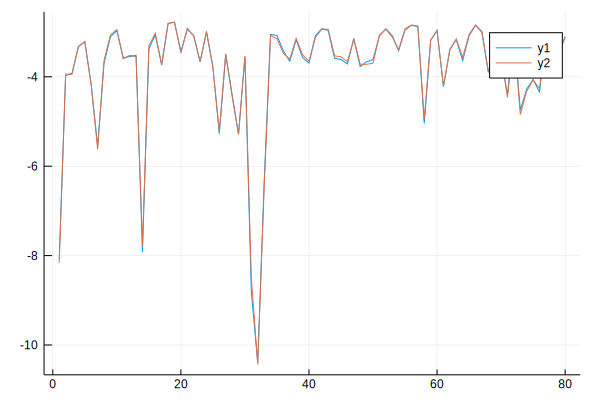

In [132]:
plot(liki)
plot!(lik)

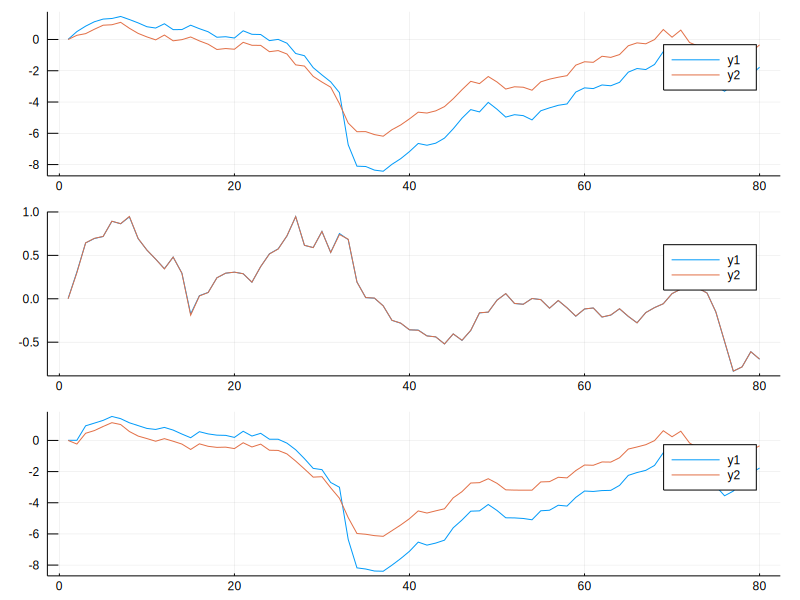

In [133]:
y1 = [mean(all_s_up[:,5,:],dims=2), statepredi[1:end-1,5]]
y2 = [mean(all_s_up[:,6,:],dims=2), statepredi[1:end-1,6]]
y3 = [mean(all_s_up[:,1,:],dims=2), statepredi[1:end-1,1]]
plot(
    plot([1:80],y1),
    plot([1:80],y2),
    plot([1:80],y3),
    layout=(3,1),size=(800,600)
)

In [134]:
liki, measurepredi, statepredi, varstatepredi = KF(A,B,H,R,S2,Phi,yt)

# N_opts = [50, 100, 1000]
N_opts = [20000]

Nrep = 100

lik_store = zeros(Nrep, size(N_opts)[1])

for r = 1:Nrep
    
    for n = 1:size(N_opts)[1]
        
        N = N_opts[n]
        
        lik, all_s_up, Neff = PF_lik(A, B, H, Phi, R, S2, N, yt, x0, P0, 1)
        
        lik_store[r,n] = sum(lik) - sum(liki)
        
    end
    
end

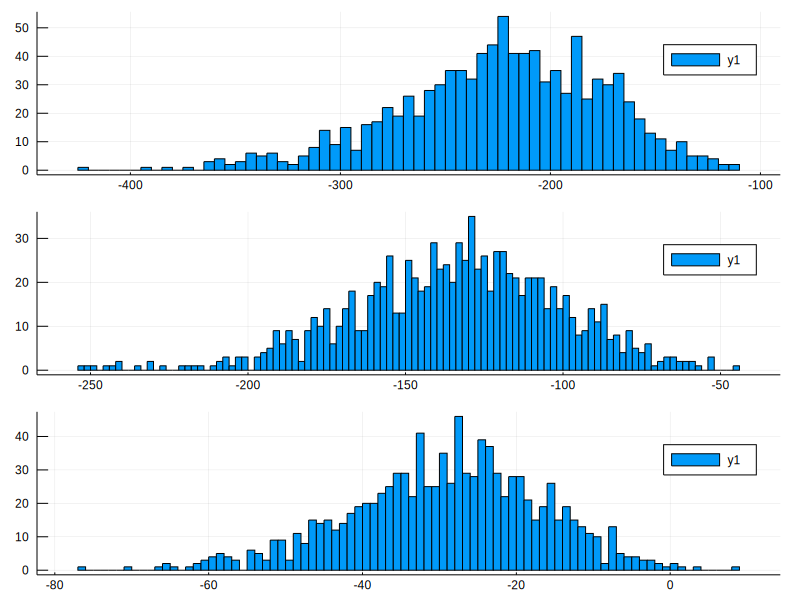

In [120]:
h1 = fit(Histogram, lik_store[:,1], nbins=Nrep/10)
plot(h1)
# h2 = fit(Histogram, lik_store[:,2], nbins=Nrep/10)
# h3 = fit(Histogram, lik_store[:,3], nbins=Nrep/10)
# plot(
#     plot(h1),
#     plot(h2),
#     plot(h3),
#     layout=(3,1),size=(800,600)
# )

In [121]:

using Test
using Distributions
using KernelDensity

import KernelDensity: kernel_dist, default_bandwidth, kde_boundary, kde_range, tabulate

for D in [Normal,Uniform,Logistic]
    d = kernel_dist(D,0.5)
    @test isa(d,D)
    @test mean(d) == 0.0
    @test std(d) ≈ 0.5
end

r = kde_range((-2.0,2.0), 128)
@test step(r) > 0
r2 = kde_range((0.12698109160784082, 0.9785547869337731), 256)
@test length(r2) == 256

for X in ([0.0], [0.0,0.0], [0.0,0.5], [-0.5:0.1:0.5;])
    w = default_bandwidth(X)
    @test w > 0
    lo, hi = kde_boundary(X,w)
    @test lo < hi
    kr = kde_range((lo,hi), 10)
    @test step(kr) > 0

    for D in (Normal, )
        k1 = tabulate(X,r)
        @test isa(k1,UnivariateKDE)
        @test length(k1.density) == length(k1.x)
        @test all(k1.density .>= 0.0)
        @test sum(k1.density)*step(k1.x) ≈ 1.0

        k2 = KernelDensity.conv(k1,kernel_dist(D,0.1))
        @test isa(k2,UnivariateKDE)
        @test length(k2.density) == length(k2.x)
        @test all(k2.density .>= 0.0)
        @test sum(k2.density)*step(k2.x) ≈ 1.0

        k3 = kde(X;kernel=D)
        @test isa(k3,UnivariateKDE)
        @test length(k3.density) == length(k3.x)
        @test all(k3.density .>= 0.0)
        @test sum(k3.density)*step(k3.x) ≈ 1.0

        k4 = kde(X,r;kernel=D)
        @test isa(k4,UnivariateKDE)
        @test length(k4.density) == length(k4.x)
        @test all(k4.density .>= 0.0)
        @test sum(k4.density)*step(k4.x) ≈ 1.0

        k5 = kde_lscv(X)
        @test isa(k5,UnivariateKDE)
        @test length(k5.density) == length(k5.x)
        @test all(k5.density .>= 0.0)
        @test sum(k5.density)*step(k5.x) ≈ 1.0

        k6 = kde(X,r;kernel=D, weights=fill(1.0/length(X),length(X)))
        @test k4.density ≈ k6.density
    end
end

k11 = kde([0.0, 1.], r, bandwidth=1, weights=[0,1])
k12 = kde([1.], r, bandwidth=1)
@test k11.density ≈ k12.density

Test Passed

In [93]:
using KernelDensity

# x = randn(100)
y = kde(lik_store[:,1])
# plot(z->pdf(y,z))

println(typeof(y))

UnivariateKDE{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}


In [85]:
using KernelDensityEstimate
# Basic one dimensional examples
# using leave-one-out likelihood cross validation for bandwidth estimation
p100 = kde!([randn(50);10.0.+2*randn(50)])
p2 = kde!([0.0;10.0],[1.0]) # multibandwidth still to be added
p75 = resample(p2,75)

# bring in the plotting functions
using KernelDensityEstimatePlotting
plot([p100;p2;p75]) #,c=["red";"green";"blue"]) # using Gadfly under the hood

ErrorException: No user recipe defined for BallTreeDensity